In [18]:
! pip install pytorch-lightning
! pip install lightning-bolts

In [19]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        self.num_classes = 10

        # encoder, decoder
        self.conv1 = nn.Conv2d(1,3,3,stride=1,padding=1,bias=False)
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )
        self.conv2 = nn.Conv2d(3,1,5,stride=1,bias=False)

        self.label_lin = nn.Linear(10, 256)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim+256, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim+256, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, batch_labels = batch

        one_hot_labels = torch.nn.functional.one_hot(batch_labels, self.num_classes)
        one_hot_labels = one_hot_labels.to(torch.float32)

        # encode x to get the mu and variance parameters
        # print(x.shape)
        x1 = self.conv1(x)
        # print(x.shape)
        x_encoded = self.encoder(x1)
        # print(x_encoded.dtype)
        # print(type(x))
        onehot_lin = self.label_lin(one_hot_labels)

        # print(x_encoded.shape)
        # print(onehot_lin.shape)
        # print(torch.cat((x_encoded,onehot_lin), dim= 1).shape)

        # print(onehot_lin.dtype)
        mu, log_var = self.fc_mu(torch.cat((x_encoded,onehot_lin), dim= 1)), self.fc_var(torch.cat((x_encoded,onehot_lin), dim=1))
        # mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)
        # print(x_hat.shape)
        x_hat = self.conv2(x_hat)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
        })

        return elbo

In [20]:

# from pl_bolts.datamodules import CIFAR10DataModule

# datamodule = CIFAR10DataModule('.')

from pl_bolts.datamodules import MNISTDataModule

datamodule = MNISTDataModule('.')

In [21]:
pl.seed_everything(1234)

cifar10 = datamodule

vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=7) #, progress_bar_refresh_rate=10)
trainer.fit(vae, cifar10)

/tmp/ipykernel_28/3860137256.py:21: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/tmp/ipykernel_28/3860137256.py:22: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(



100%|██████████| 9912422/9912422 [00:00<00:00, 171242858.97it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 28881/28881 [00:00<00:00, 72061685.80it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 34445121.01it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22924824.03it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Training: 0it [00:00, ?it/s]

tensor(2) 1 torch.Size([1, 28, 28])
tensor(8) 2 torch.Size([1, 28, 28])
tensor(7) 3 torch.Size([1, 28, 28])
tensor(9) 4 torch.Size([1, 28, 28])
tensor(2) 5 torch.Size([1, 28, 28])
tensor(1) 6 torch.Size([1, 28, 28])
tensor(5) 7 torch.Size([1, 28, 28])
tensor(2) 8 torch.Size([1, 28, 28])
tensor(8) 9 torch.Size([1, 28, 28])
tensor(6) 10 torch.Size([1, 28, 28])
tensor(6) 11 torch.Size([1, 28, 28])
tensor(5) 12 torch.Size([1, 28, 28])
tensor(7) 13 torch.Size([1, 28, 28])
tensor(3) 14 torch.Size([1, 28, 28])
tensor(4) 15 torch.Size([1, 28, 28])
tensor(6) 16 torch.Size([1, 28, 28])
tensor(2) 17 torch.Size([1, 28, 28])
tensor(0) 18 torch.Size([1, 28, 28])
tensor(8) 19 torch.Size([1, 28, 28])
tensor(4) 20 torch.Size([1, 28, 28])
tensor(9) 21 torch.Size([1, 28, 28])
tensor(7) 22 torch.Size([1, 28, 28])
tensor(6) 23 torch.Size([1, 28, 28])
tensor(2) 24 torch.Size([1, 28, 28])
tensor(3) 25 torch.Size([1, 28, 28])
<class 'numpy.ndarray'>


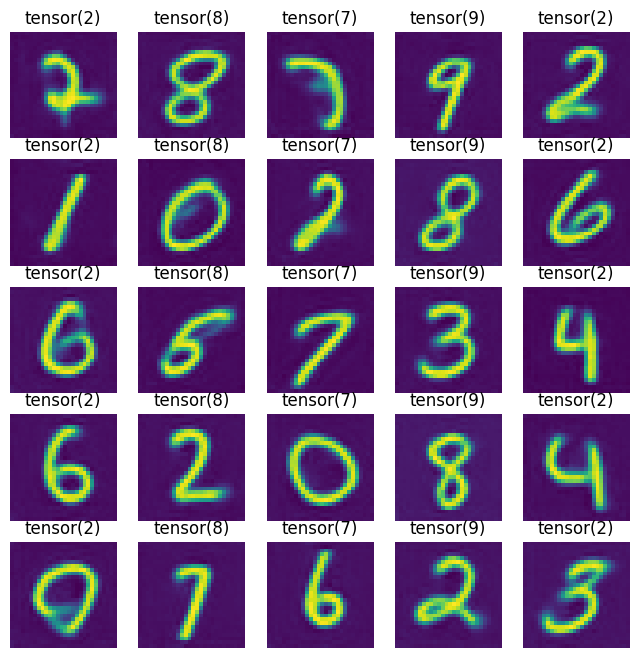

In [24]:

import matplotlib.pyplot as plt

# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
# print(type(std), type(mean))

i=0
pred=[]
for data, labels in cifar10.val_dataloader():
  for j, label in enumerate(labels):
    i=i+1
    if i>=26:
      break
    print(labels[j], i, data[j].shape)
    img = data[j].unsqueeze(0)
    with torch.no_grad():
      # pred1 = vae(img.to(vae.device), labels[j].to(vae.device)).cpu()
        one_hot_labels = torch.nn.functional.one_hot(labels[j].to(vae.device), vae.num_classes)
        one_hot_labels = one_hot_labels.to(torch.float32)

        # encode x to get the mu and variance parameters
        img = vae.conv1(img.to(vae.device))
        x_encoded = vae.encoder(img)
        # print(x_encoded.dtype)
        # print(type(x))
        onehot_lin = vae.label_lin(one_hot_labels).unsqueeze(0)
        # print(onehot_lin.shape)
        # print(x_encoded.shape)
        mu, log_var = vae.fc_mu(torch.cat((x_encoded,onehot_lin), dim= 1)), vae.fc_var(torch.cat((x_encoded,onehot_lin), dim=1))
        # print(onehot_lin.dtype)
        # mu, log_var = vae.fc_mu(x_encoded+onehot_lin), vae.fc_var(x_encoded)
        # mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)
        x_hat = vae.conv2(x_hat)
        # print(type(x_hat.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()))
        pred.append(x_hat.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())

  if i>=26:
    break
# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
# normalize = mnist_normalization()
mean, std = np.array((0.1307,)), np.array((0.3081,))
# img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

print(type(pred[0]))

num_rows = 5
num_cols = 5

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# Iterate through the images and display them in the grid
for i in range(num_rows):
    for j in range(num_cols):
        if i * num_cols + j < len(pred):
            axes[i, j].imshow(np.array(pred[i * num_cols + j]) * std + mean)
            axes[i, j].set_title(labels[j])
            axes[i, j].axis('off')  # Turn off axis labels

tensor(2) 1 torch.Size([1, 28, 28])
tensor(8) 2 torch.Size([1, 28, 28])
tensor(7) 3 torch.Size([1, 28, 28])
tensor(9) 4 torch.Size([1, 28, 28])
tensor(2) 5 torch.Size([1, 28, 28])
tensor(1) 6 torch.Size([1, 28, 28])
tensor(5) 7 torch.Size([1, 28, 28])
tensor(2) 8 torch.Size([1, 28, 28])
tensor(8) 9 torch.Size([1, 28, 28])
tensor(6) 10 torch.Size([1, 28, 28])
tensor(6) 11 torch.Size([1, 28, 28])
tensor(5) 12 torch.Size([1, 28, 28])
tensor(7) 13 torch.Size([1, 28, 28])
tensor(3) 14 torch.Size([1, 28, 28])
tensor(4) 15 torch.Size([1, 28, 28])
tensor(6) 16 torch.Size([1, 28, 28])
tensor(2) 17 torch.Size([1, 28, 28])
tensor(0) 18 torch.Size([1, 28, 28])
tensor(8) 19 torch.Size([1, 28, 28])
tensor(4) 20 torch.Size([1, 28, 28])
tensor(9) 21 torch.Size([1, 28, 28])
tensor(7) 22 torch.Size([1, 28, 28])
tensor(6) 23 torch.Size([1, 28, 28])
tensor(2) 24 torch.Size([1, 28, 28])
tensor(3) 25 torch.Size([1, 28, 28])
<class 'numpy.ndarray'>


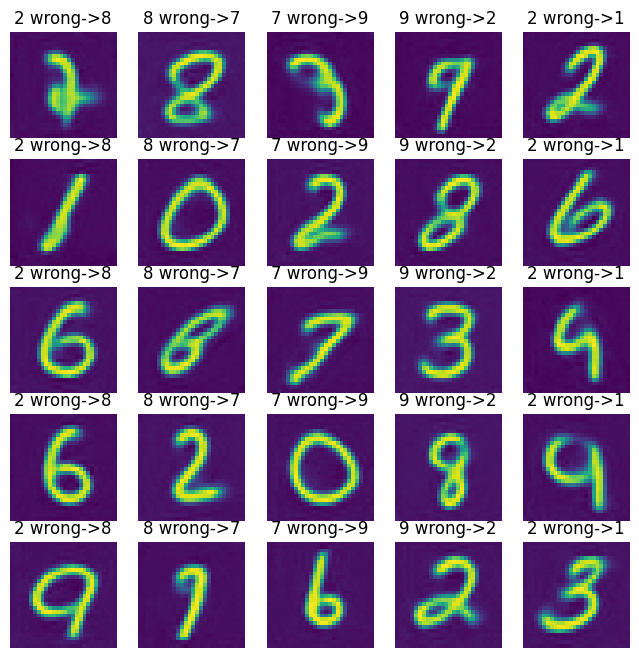

In [26]:

import matplotlib.pyplot as plt

# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
# print(type(std), type(mean))

i=0
pred=[]
for data, labels in cifar10.val_dataloader():
  for j, label in enumerate(labels):
    i=i+1
    if i>=26:
      break
    print(labels[j], i, data[j].shape)
    img = data[j].unsqueeze(0)
    with torch.no_grad():
      # pred1 = vae(img.to(vae.device), labels[j].to(vae.device)).cpu()
        one_hot_labels = torch.nn.functional.one_hot(labels[j+1].to(vae.device), vae.num_classes)
        one_hot_labels = one_hot_labels.to(torch.float32)

        # encode x to get the mu and variance parameters
        img = vae.conv1(img.to(vae.device))
        x_encoded = vae.encoder(img)
        # print(x_encoded.dtype)
        # print(type(x))
        onehot_lin = vae.label_lin(one_hot_labels).unsqueeze(0)
        # print(onehot_lin.shape)
        # print(x_encoded.shape)
        mu, log_var = vae.fc_mu(torch.cat((x_encoded,onehot_lin), dim= 1)), vae.fc_var(torch.cat((x_encoded,onehot_lin), dim=1))
        # print(onehot_lin.dtype)
        # mu, log_var = vae.fc_mu(x_encoded+onehot_lin), vae.fc_var(x_encoded)
        # mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)
        x_hat = vae.conv2(x_hat)
        # print(type(x_hat.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()))
        pred.append(x_hat.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())

  if i>=26:
    break
# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
# normalize = mnist_normalization()
mean, std = np.array((0.1307,)), np.array((0.3081,))
# img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

print(type(pred[0]))

num_rows = 5
num_cols = 5

# Create a new figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# Iterate through the images and display them in the grid
for i in range(num_rows):
    for j in range(num_cols):
        if i * num_cols + j < len(pred):
            axes[i, j].imshow(np.array(pred[i * num_cols + j]) * std + mean)
            axes[i, j].set_title(f'{labels[j]} wrong->{labels[j+1]}')
            axes[i, j].axis('off')  # Turn off axis labels